## Required additional feedforward weight to compensate for fewer neurons
Comparable to linear rate model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_3a_requiredFFweight_competition import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


%load_ext autoreload
%autoreload 2

### Scan parameter range

In [2]:
fname_res = 'data/3a_r_twoseqs.pckl'
t = params['t']


In [3]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)
    
else:

    r = np.zeros([
        len(params['range_nE1']),
        len(params['range_pot_ff1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, nE_1 in enumerate(tqdm(params['range_nE1'])):
        for j, pot_ff_1 in enumerate(params['range_pot_ff1']):
            sim = sim_wc.Simulator(params)
            nE = params['nE']
            nI = params['nI']
            sim.p['nE'][1] = nE_1
            sim.p['nI'][1] = int(nE_1*0.25)
            pot_ff = params['pot_ff']
            sim.p['pot_ff'][1] = pot_ff_1
            sim.set_interaction_matrix()
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

In [4]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs'])
], dtype=bool)
cond = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs']),
    4], dtype=bool)
mean_t_act = np.zeros([
    len(params['range_nE1']),
    len(params['range_pot_ff1']),
    len(params['seqs'])])
    

dt = np.mean(np.unique(np.diff(params['t'])))

for i, nE_i in enumerate(params['range_nE1']):
    for j, _ in enumerate(params['range_pot_ff1']):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            (crit[i, j, m],
             cond[i, j, m, 0],
             cond[i, j, m, 1],
             cond[i, j, m, 2],
             cond[i, j, m, 3]) = tools_wc.peak_criterium(
                rE_ijm, params['r_min'],
                seq_m_pos, params['tol'],
                return_conds=True)
            mean_t_act[i, j, m] = tools_wc.mean_activation_time(
                rE_ijm, params['r_min'], dt)

### Create linear approximation

In [5]:
try:
    fun_lin = tools_wc.import_if_exists('lin_approx', 'minimal_p_11ff_2seqs')
    p__11_ff_lin = []
    for M__1_i in params['range_nE1']:
        p__11_ff_i = fun_lin(
            c=params['c'],
            M__E0=params['nE'][0],
            r__E0_i_minus_1=1.,
            p_rc=params['p_rc'],
            g__11_ff=params['gE']*params['pot_ff'][1],
            M__E1=M__1_i,
            g__01_ffi=params['gE'],
            p_ffi=params['p_ffi'],
            g_rc=params['gE'],
        )
        p__11_ff_lin.append(p__11_ff_i)

except Exception as error:
    # handle the exception
    print("An exception occurred:", error) # An exception occurred: division by zero
    pass

### Store results for 3b

In [6]:
tools_wc.save_pckl(crit, 'data/3a_r_twoseqs_crit')
tools_wc.save_pckl(
    np.column_stack(
        (params['range_nE1'], np.array(p__11_ff_lin))
    ), 'data/3a_r_twoseqs_linapprox')

### Plot results 

In [7]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

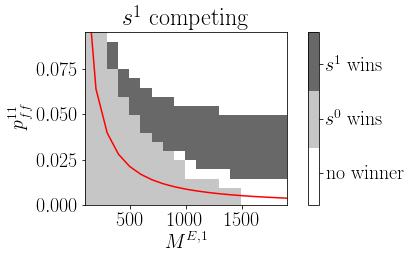

In [8]:
piv = np.sum(crit, axis=2)
f = 0.1
piv = piv - f*crit[:, :, 0]
piv = piv + f*crit[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(6,4))


# adjust xticks to represent sum of nE and nI
rng_nE1 = params['range_nE1'] 
xticks = rng_nE1

#a[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(xticks, params['p_ff']*params['range_pot_ff1'], piv.T, cmap=cmap, norm=norm)

ax[0,0].set_title('$s^1$ competing', fontsize=24)

ax[0,0].set_xlabel('$M^{E,1}$')
ax[0,0].set_ylabel('$p^{11}_{ff}$')

y_range = params['p_ff']*params['range_pot_ff1']
ax[0,0].set_ylim(y_range[0], y_range[-1])
ax[0,0].set_xlim(params['range_nE1'][0], params['range_nE1'][-1])


ax2 = ax[0, 1]

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['no winner',
     '$s^0$ wins',
     '$s^1$ wins'])

# insert linear approximation
if p__11_ff_lin:
    ax[0,0].plot(params['range_nE1'], p__11_ff_lin, c='red')

fig.tight_layout()

fig.savefig('figures/3a_FFweightScalesNonlinearly.svg')

### Supplementary plots

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'linewidth'
  del sys.path[0]


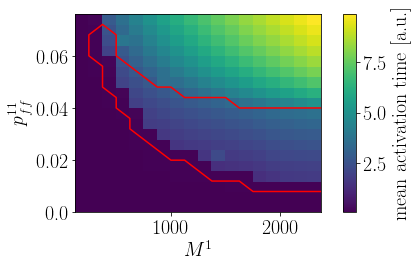

In [9]:
fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(6,4))


# adjust xticks to represent sum of nE and nI
rng_nE1 = params['range_nE1'] 
xticks = rng_nE1 + rng_nE1*0.25

#a[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(xticks, params['range_pot_ff1'], mean_t_act[:,:,1].T)
contour = ax[0,0].contour(
    xticks, params['range_pot_ff1'],
    crit[:, :, 1].T, colors='red', 
    linewidth=0.1, levels=[False, True],)


ax[0,0].set_xlabel('$M^{1}$')

ax2 = ax[0, 1]

yticks = ax[0,0].get_yticks()
yticks *= params['p_ff']
ax[0,0].set_yticklabels(np.round(yticks, 3))
ax[0,0].set_ylabel(r'$p^{11}_{ff}$')

cb = plt.colorbar(heatmap, cax=ax2)
cb.ax.set_ylabel('mean activation time [a.u.]', rotation=90)

fig.tight_layout()

fig.savefig('figures/3a_FFweightScalesNonlinearly_suppl_meantact.svg')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'


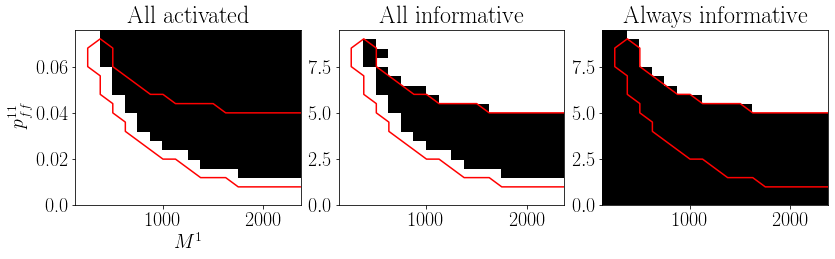

In [10]:
piv = np.sum(crit, axis=2)
f = 0.1
piv = piv - f*crit[:, :, 0]
piv = piv + f*crit[:, :, 1]

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(12,4))


# adjust xticks to represent sum of nE and nI
rng_nE1 = params['range_nE1'] 
xticks = rng_nE1 + rng_nE1*0.25

ls_cond = [0, 1, 2]
ls_title = ['All activated', 'All informative', 'Always informative']

for i in ls_cond:
    heatmap = ax[0,i].pcolormesh(xticks, params['range_pot_ff1'], cond[:,:, 1, i].T, vmin=0, vmax=1, cmap='Greys')
    contour = ax[0,i].contour(
        xticks, params['range_pot_ff1'],
        crit[:, :, 1].T, colors='red', 
        linewidth=0.1, levels=[False, True],)
    ax[0, i].set_title(ls_title[i])

#a[0,0].set_aspect('equal')
#heatmap = ax[0,0].pcolormesh(xticks, params['range_pot_ff1'], piv.T, cmap=cmap, norm=norm)
#ax[0,0].set_ylabel(r'n^{E,0}$')
#ax[0,0].set_xlabel(r'n^{E,1}$')
#ax[0,0].set_xticks([params['range_nE1'][0], params['range_nE1'][-1]])
#ax[0,0].set_yticks([params['range_pot_ff1'][0], params['range_pot_ff1'][-1]])
#ax[0,0].set_title('Competition scenarios', fontsize=24)

ax[0,0].set_xlabel('$M^{1}$')

ax2 = ax[0, 1]

# adjust ticklabels to represent gE instead of potentiation factor
yticks = ax[0,0].get_yticks()
yticks *= params['p_ff']
ax[0,0].set_yticklabels(np.round(yticks, 3))
ax[0,0].set_ylabel(r'$p^{11}_{ff}$')


fig.tight_layout()
fig.savefig('figures/3a_FFweightScalesNonlinearly_suppl_cond.svg')